# Energy Versus M

In [1]:
path_file = r"C:\Users\Vikas Vijigiri\Documents\IT_QMC_H2SQ_Nov_2024 - Latest\files\betaVp_100\fangleVp_0\L4\J2_0.00\J3_0.00\M1\IT_data_avg.txt"


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv(path_file, sep=r"\s+")

In [4]:
df

,Lx,Ly,Nl,M,T,J0,J1,J2,J3,h,enrg,enrg2,enrg4,enrg_trans,mag_x,mag_xSq
0,4,4,1,16,0.05,1.250000,0.250000,0.062500,0.0,0.1,-0.762435,0.581308,0.337919,-0.000622,0.006218,3.865917e-05
1,4,4,1,32,0.05,0.625000,0.125000,0.031250,0.0,0.1,-0.756242,0.571902,0.327072,-0.000312,0.003121,9.740250e-06
2,4,4,1,64,0.05,0.312500,0.062500,0.015625,0.0,0.1,-0.753124,0.567196,0.321711,-0.000156,0.001562,2.439818e-06
3,4,4,1,128,0.05,0.156250,0.031250,0.007812,0.0,0.1,-0.751562,0.564846,0.319051,-0.000078,0.000781,6.102522e-07
4,4,4,1,256,0.05,0.078125,0.015625,0.003906,0.0,0.1,-0.750781,0.563673,0.317727,-0.000039,0.000391,1.525817e-07


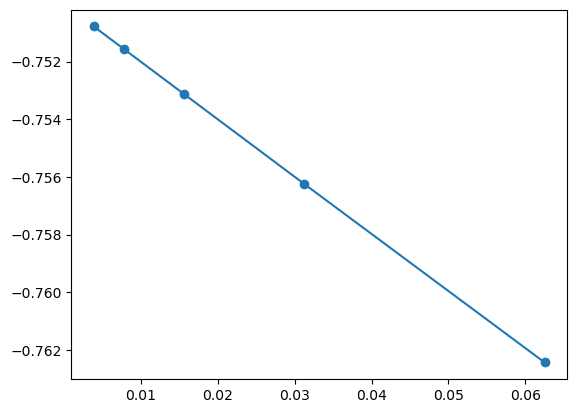

In [7]:
plt.plot(1/df['M'], df['enrg'], label='Energy', marker='o', linestyle='-',)
plt.show()

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

In [53]:
X = 1/df[['M']]
y = df['enrg']

In [54]:
# Logistic regression model
model = LinearRegression()  # max_iter for convergence
model.fit(X, y)

LinearRegression()

In [62]:
# Predict for larger M
X_test = np.array([[0]])  # (1 sample, 4 features)
E_pred = model.predict(X_test)

c:\Conda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [63]:
E_pred

array([-0.75001212])

In [ ]:
# slmc_tfim_finiteT.py
# Run: python slmc_tfim_finiteT.py
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import random, time, math, statistics

# -------------------------
# User parameters
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Lx, Ly = 4, 4         # spatial size
M = 10                # Trotter slices (time dimension)
J = 1.0
Gamma = 1.0
beta = 4.0            # inverse temperature
Delta = beta / M
J_sp = Delta * J
K_tau = 0.5 * np.log(1.0 / np.tanh(Gamma * Delta))  # 0.5 ln coth(Gamma*Delta)
print("Lx,Ly,M", Lx, Ly, M, "J_sp", J_sp, "K_tau", K_tau)

n_initial_mc = 5000    # baseline MC steps to collect dataset
thin = 5               # collect every `thin` steps
n_train_epochs = 60
batch_size = 64

# MC sweep counts
baseline_sweeps = 1    # sweeps per step when collecting baseline
heff_relax_sweeps = 20 # sweeps on H_eff to generate proposals

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# -------------------------
# Helpers: index operations
# -------------------------
def neighbors(x, y):
    return [((x+1)%Lx, y), ((x-1)%Lx, y), (x, (y+1)%Ly), (x, (y-1)%Ly)]

# -------------------------
# Classical energy function
# spins: ndarray shape (M, Lx, Ly) values in {+1, -1}
# -------------------------
def E_true(spins):
    # spatial bonds (sum over tau and spatial nearest neighbors)
    E_sp = 0.0
    for tau in range(M):
        s = spins[tau]
        # sum over bonds without double counting: (x,y) -> (x+1,y) and (x,y)->(x,y+1)
        for x in range(Lx):
            for y in range(Ly):
                sx = s[x,y]
                sx_r = s[(x+1)%Lx, y]
                sx_u = s[x, (y+1)%Ly]
                E_sp += -J_sp * sx * sx_r
                E_sp += -J_sp * sx * sx_u
    # temporal bonds (between tau and tau+1)
    E_tmp = 0.0
    for tau in range(M):
        s = spins[tau]
        snext = spins[(tau+1)%M]
        E_tmp += -K_tau * np.sum(s * snext)
    return E_sp + E_tmp

# vectorized compute for batch
def E_true_batch(spins_batch):
    # spins_batch: (B, M, Lx, Ly)
    out = np.zeros(spins_batch.shape[0], dtype=float)
    for i in range(spins_batch.shape[0]):
        out[i] = E_true(spins_batch[i])
    return out

# -------------------------
# Baseline MC: local Metropolis sweep (single-spin flips)
# -------------------------
def local_metropolis_sweep(spins, beta_cl=1.0):
    # spins shape (M,Lx,Ly)
    for tau in range(M):
        s = spins[tau]
        for x in range(Lx):
            for y in range(Ly):
                old = s[x,y]
                new = -old
                # compute delta E from spatial neighbors at same tau
                dE = 0.0
                for (nx, ny) in neighbors(x,y):
                    dE += -J_sp * (new - old) * s[nx, ny]
                # temporal neighbors
                s_prev = spins[(tau-1)%M, x, y]
                s_next = spins[(tau+1)%M, x, y]
                dE += -K_tau * (new - old) * (s_prev + s_next)
                # Metropolis
                if dE <= 0 or random.random() < math.exp(-beta_cl * dE):
                    s[x,y] = new
    return spins

# -------------------------
# Data collection
# -------------------------
def collect_baseline_data(n_steps):
    configs = []
    spins = np.random.choice([1,-1], size=(M,Lx,Ly))
    for step in range(n_steps):
        for _ in range(baseline_sweeps):
            spins = local_metropolis_sweep(spins, beta_cl=1.0)  # we've embedded beta via J_sp and K_tau
        if step % thin == 0:
            configs.append(spins.copy())
    return np.array(configs)  # shape (N, M, Lx, Ly)

print("Collecting baseline MC data...")
data_configs = collect_baseline_data(n_initial_mc)
print("Collected", len(data_configs), "configs")
energies = E_true_batch(data_configs)
print("E range:", energies.min(), energies.max(), "mean", energies.mean())

# -------------------------
# PyTorch dataset & 3D-CNN surrogate
# input: (B, 1, M, Lx, Ly) with values in {-1,1}
# model outputs scalar energy
# -------------------------
class Heff3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input channels = 1 (spin), shape (B,1,M,Lx,Ly)
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool3d((1,1,1))
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out.view(-1)

# prepare PyTorch data
X = torch.tensor(data_configs[:, None, :, :, :].astype(np.float32), device=device)  # B,1,M,Lx,Ly
Y = torch.tensor(energies.astype(np.float32), device=device)
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# instantiate model
model = Heff3DCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# normalize target energies (helps optimization)
E_mean = energies.mean()
E_std = energies.std() if energies.std()>0 else 1.0
print("Energy mean,std:", E_mean, E_std)

# training
print("Training surrogate H_eff ...")
for epoch in range(n_train_epochs):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        yb_norm = (yb - E_mean) / E_std
        pred = model(xb)
        loss = loss_fn(pred, yb_norm)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(dataset)
    if (epoch+1) % 10 == 0 or epoch==0:
        print(f"Epoch {epoch+1}/{n_train_epochs}, loss {avg_loss:.6f}")
print("Training done.")

# helper to compute H_eff quickly (numpy wrapper)
def H_eff_numpy(spins_np):
    # spins_np shape (M,Lx,Ly)
    x = torch.tensor(spins_np[None, None, :, :, :].astype(np.float32), device=device)
    with torch.no_grad():
        out = model(x).cpu().numpy().squeeze()
    # denormalize
    return float(out * E_std + E_mean)

# -------------------------
# SLMC: propose configs by running cheap MCMC on H_eff, accept with MH using E_true
# We'll implement: start from current config, run many local Metropolis sweeps using H_eff
# as energy (i.e., compute dE using H_eff cheaply via local re-evaluation).
# For speed in prototype, we'll run random single-spin flips evaluated using H_eff via full eval.
# (This is not the most optimal but simple to implement here.)
# -------------------------
def propose_via_heff(spins, n_sweeps):
    # spins: numpy array (M,Lx,Ly)
    cur = spins.copy()
    for sweep in range(n_sweeps):
        # random single-spin attempt many times
        for _ in range(M*Lx*Ly//2):
            tau = random.randrange(M)
            x = random.randrange(Lx)
            y = random.randrange(Ly)
            cur_val = cur[tau, x, y]
            cur[tau, x, y] = -cur_val
            # compute H_eff difference by evaluating H_eff full (cheap)
            heff_new = H_eff_numpy(cur)
            cur[tau, x, y] = cur_val
            heff_old = H_eff_numpy(cur)
            d_heff = heff_new - heff_old
            # Metropolis on H_eff (we use beta=1 on classical energy scale already)
            if d_heff <= 0 or random.random() < math.exp(-d_heff):
                cur[tau, x, y] = -cur_val
    return cur

# -------------------------
# Full SLMC sampling loop
# -------------------------
n_slmc_steps = 200    # number of SLMC proposals (small for demo)
spins_cur = data_configs[-1].copy()  # start from last baseline config
E_cur = E_true(spins_cur)
accepts = 0
E_hist = []
acc_probs = []

print("Starting SLMC sampling...")
t0 = time.time()
for step in range(n_slmc_steps):
    # propose from H_eff
    s_prop = propose_via_heff(spins_cur, heff_relax_sweeps)  # returns candidate config
    # compute H_true and H_eff for MH correction
    E_prop = E_true(s_prop)
    Hcur_eff = H_eff_numpy(spins_cur)
    Hprop_eff = H_eff_numpy(s_prop)
    # acceptance probability (beta=1 in classical energy)
    # A = min(1, exp( - (E_prop - E_cur) + (Hcur_eff - Hprop_eff) ))
    arg = - (E_prop - E_cur) + (Hcur_eff - Hprop_eff)
    A = min(1.0, math.exp(arg)) if arg < 700 else 1.0  # guard overflow
    acc_probs.append(A)
    if random.random() < A:
        spins_cur = s_prop
        E_cur = E_prop
        accepts += 1
    E_hist.append(E_cur)
    if (step+1) % 20 == 0:
        print(f"step {step+1}/{n_slmc_steps}, acc_rate={accepts/(step+1):.3f}, E={E_cur:.4f}, meanA={np.mean(acc_probs):.3f}")

t1 = time.time()
print("SLMC done. time(s):", t1-t0, "accepts", accepts, "acc_rate", accepts/n_slmc_steps)
print("Energy stats (last 50):", np.mean(E_hist[-50:]), np.std(E_hist[-50:]))

# quick baseline comparison: run same number of baseline Metropolis steps and show acceptance-ish proxy
spins_test = data_configs[-1].copy()
E_hist_base = []
for step in range(n_slmc_steps):
    spins_test = local_metropolis_sweep(spins_test)
    E_hist_base.append(E_true(spins_test))
print("Baseline mean E (last 50):", np.mean(E_hist_base[-50:]), np.std(E_hist_base[-50:]))


Device: cpu
Lx,Ly,M 6 6 10 J_sp 0.4 K_tau 0.4838591725683765
Collected 1000 configs
E range: -462.18930212461635 -147.66310070820538 mean -449.7553768845089
Energy mean,std: -449.7553768845089 12.697970537091843
Training surrogate H_eff ...
Epoch 1/60, loss 0.997920
Epoch 10/60, loss 0.064813
Epoch 20/60, loss 0.098270
Epoch 30/60, loss 0.055192
Epoch 40/60, loss 0.016100
Epoch 50/60, loss 0.019136
Epoch 60/60, loss 0.008266
Training done.
Starting SLMC sampling...
